In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

# 評価指標
import sys
sys.path.append('./evaluation')
from rmse import rmse
from recall5 import recall5
from profit import profit

# #エヴァリュエーション
# from sklearn.metrics import precision_score, recall_score, mean_squared_error

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

#保存
import pickle

In [2]:
#データを読み込む
n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

In [3]:
# 新しいグループを作成
n_uma_race_df['group'] = n_uma_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_uma_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_uma_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_uma_race_df['race_bango'].astype(int).astype(str)
n_race_df['group'] = n_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_race_df['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

n_race_df_drop = n_race_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df_drop = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

merged_df = pd.merge(n_uma_race_df, n_race_df_drop, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df_drop, on='group', how='left')
merged_df['group'].nunique()

205318

In [4]:
merged_df['hutan_wariai'] = merged_df['futan_juryo'] / merged_df['bataiju']
def combine_sign_and_diff(row):
    if row['zogen_fugo'] == 2:
        return row['zogen_sa']
    elif row['zogen_fugo'] == 0:
        return -row['zogen_sa']
    else:
        return 0

merged_df['zogen_ryou'] = merged_df.apply(combine_sign_and_diff, axis=1)
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]

In [5]:
columns_to_convert = [
                    'kyori',
                    'grade_code',
                    'seibetsu_code',
                    'moshoku_code',
                    'barei',
                    'chokyoshi_code',
                    'banushi_code',
                    'kishu_code',
                    'kishu_minarai_code',
                    'kyoso_shubetsu_code',
                    'juryo_shubetsu_code',
                    'shusso_tosu',
                    'tenko_code',
                    'babajotai_code_dirt',
                    'hutan_wariai',
                    'zogen_ryou',
                    'track_code',
                    'keibajo_code',
                    'hinshu_code',
                    'umakigo_code'
                    ]

for column in columns_to_convert:
    merged_df[column].fillna(0, inplace=True)
    try:
        if merged_df[column].astype(float).apply(lambda x: x.is_integer()).all():
            merged_df[column] = merged_df[column].astype(int)
        else:
            merged_df[column] = merged_df[column].astype(float)
    except ValueError:
        merged_df[column] = merged_df[column].astype(float)

    print(f"{column} のデータ型: {merged_df[column].dtype}")

kyori のデータ型: int32
grade_code のデータ型: int32
seibetsu_code のデータ型: int32
moshoku_code のデータ型: int32
barei のデータ型: int32
chokyoshi_code のデータ型: int32
banushi_code のデータ型: int32
kishu_code のデータ型: int32
kishu_minarai_code のデータ型: int32
kyoso_shubetsu_code のデータ型: int32
juryo_shubetsu_code のデータ型: int32
shusso_tosu のデータ型: int32
tenko_code のデータ型: int32
babajotai_code_dirt のデータ型: int32
hutan_wariai のデータ型: float64
zogen_ryou のデータ型: int32
track_code のデータ型: int32
keibajo_code のデータ型: int32
hinshu_code のデータ型: int32
umakigo_code のデータ型: int32


In [6]:
def modify_rankings(df, column_name='kakutei_chakujun'):
    """
    この関数はDataFrameの特定の列のランキングを修正します。
    - df: DataFrameオブジェクト
    - column_name: 修正する列の名前（デフォルトは 'kakutei_chakujun'）
    """
    conditions = [
        (df[column_name] == 1),
        (df[column_name] == 2),
        (df[column_name] == 3),
        (df[column_name] == 4),
        (df[column_name] == 5)
    ]
    
    values = [5, 4, 3, 2, 1]
    
    df['target'] = np.select(conditions, values, default=0)
    
    return df
merged_df = modify_rankings(merged_df)

In [7]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
test_data = merged_df[merged_df['kaisai_nen'].isin([2020, 2021, 2022])]

In [8]:
features = [
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            'hutan_wariai',
            'zogen_ryou',
            ]

target = 'target'

In [9]:
categorical_features = ['seibetsu_code',
                        'moshoku_code',
                        'chokyoshi_code',
                        'banushi_code',
                        'kishu_code',
                        'kishu_minarai_code',
                        'hinshu_code',
                        'umakigo_code',
                       ]

In [10]:
# モデルの保存先パス
model_save_path = './bestmodels/lightgbmranker.pkl'

# モデルの読み込み
with open(model_save_path, 'rb') as f:
    loaded_model = pickle.load(f)

In [11]:
# 予測を実行
predictions = loaded_model.predict(test_data[features])

# 予測結果を'y_pred'列としてtest_dataに追加
test_data.loc[:, 'y_pred'] = predictions

C:\Users\kawam\AppData\Local\Temp\ipykernel_28256\1285198973.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'y_pred'] = predictions


In [12]:
test_data.loc[:, 'predicted_rank'] = test_data.groupby('group')['y_pred'].rank(ascending=False, method='min')

C:\Users\kawam\AppData\Local\Temp\ipykernel_28256\49177834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'predicted_rank'] = test_data.groupby('group')['y_pred'].rank(ascending=False, method='min')


In [13]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'predicted_rank').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000
is_correct_df = test_data.groupby('group').apply(check_top3_in_top5_predictions).reset_index(name='is_correct')
profit_df = test_data.groupby('group').apply(calculate_group_profit).reset_index(name='profit')
result_df = is_correct_df.merge(profit_df, on='group', how='left')

In [14]:
result_df = result_df.merge(n_race_df, on='group', how='left')

In [15]:
result_df['is_correct'] = result_df['is_correct'].astype(int)

In [16]:
pd.set_option('display.max_columns', None)
result_df.head(1)

,group,is_correct,profit,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt
0,2020-1001-30-1,0,-1000.0,2020,1001,30,13,3,1,7,0,0,11,0,9,0,0,0,0,0,1500,24,0,5.000000e+51,0,1435,7,7,7,2,0,2.0


In [17]:
# 月日の変換
result_df['kaisai_tsukihi'] = result_df['kaisai_tsukihi'].astype(str)
result_df['kaisai_month'] = result_df['kaisai_tsukihi'].str[:-2].astype(int)
result_df['kaisai_day'] = result_df['kaisai_tsukihi'].str[-2:].astype(int)

In [18]:
column_list = ['kaisai_nen', 
               'kaisai_month',
               'kaisai_day',
               'keibajo_code', 
               'kaisai_nichime', 
               'race_bango', 
               'grade_code', 
               'kyoso_shubetsu_code', 
               'kyoso_kigo_code',
               'juryo_shubetsu_code',
               'kyoso_joken_code',
               'track_code',
               'course_kubun',
               'tenko_code',
               'babajotai_code_shiba',
               'babajotai_code_dirt',
               'kyori',
               'honshokin', 
               'shusso_tosu', 
              ]

In [19]:
result_df[column_list].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45107 entries, 0 to 45106
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   kaisai_nen            45107 non-null  int64  
 1   kaisai_month          45107 non-null  int32  
 2   kaisai_day            45107 non-null  int32  
 3   keibajo_code          45107 non-null  int64  
 4   kaisai_nichime        45107 non-null  int64  
 5   race_bango            45107 non-null  int64  
 6   grade_code            45107 non-null  int64  
 7   kyoso_shubetsu_code   45107 non-null  int64  
 8   kyoso_kigo_code       45107 non-null  int64  
 9   juryo_shubetsu_code   45107 non-null  int64  
 10  kyoso_joken_code      45107 non-null  int64  
 11  track_code            45107 non-null  int64  
 12  course_kubun          45107 non-null  int64  
 13  tenko_code            45107 non-null  int64  
 14  babajotai_code_shiba  45107 non-null  int64  
 15  babajotai_code_dirt

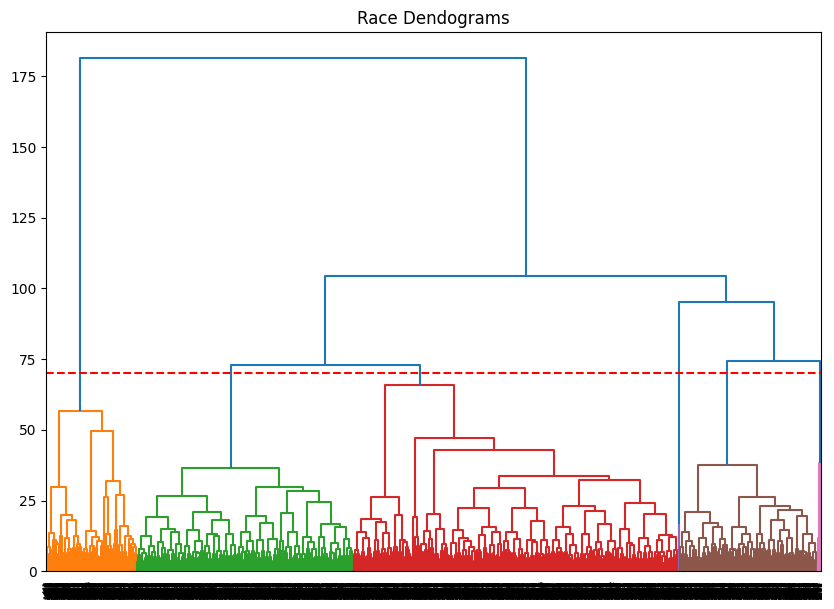

In [22]:
import pandas as pd
import numpy as np
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import fcluster

# データのサブセットを取得
sample_df = result_df.sample(frac=0.1, random_state=1)

# ダミー変数の作成
sample_df_encoded = pd.get_dummies(sample_df[column_list], drop_first=True)

# 欠損値を0で穴埋め
sample_df_encoded.fillna(0, inplace=True)

# 無限大の値が含まれていないことを確認
if np.any(np.isinf(sample_df_encoded)):
    # 無限大の値がある場合は、適当な数値（例えば NaN）で置換
    sample_df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 無限大の値を置換した後に再度欠損値を0で穴埋め
    sample_df_encoded.fillna(0, inplace=True)

# スケーリング
scaler = StandardScaler()
sample_df_scaled = scaler.fit_transform(sample_df_encoded)

# リンケージ行列の計算
linked = shc.linkage(sample_df_scaled, method='ward')

# クラスタラベルの割り当て
clusters = fcluster(linked, t=70, criterion='distance')

# sample_dfにclusterカラムを追加
sample_df['cluster'] = clusters

# グラフの表示
plt.figure(figsize=(10, 7))
plt.title("Race Dendograms")
dend = shc.dendrogram(linked, color_threshold=70)
plt.axhline(y=70, color='r', linestyle='--')
plt.show()


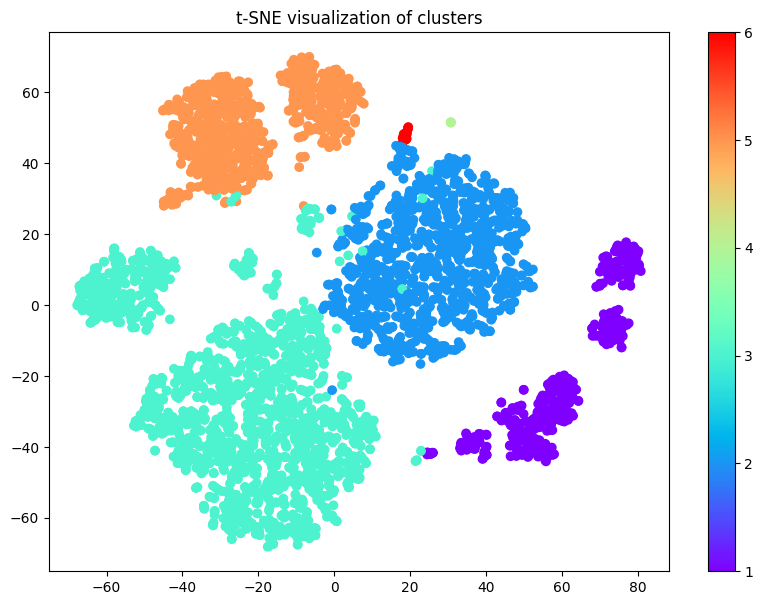

In [23]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# t-SNEの適用
tsne = TSNE(n_components=2, random_state=42)
sample_df_tsne = tsne.fit_transform(sample_df_scaled)

# 可視化
plt.figure(figsize=(10, 7))
plt.scatter(sample_df_tsne[:, 0], sample_df_tsne[:, 1], c=sample_df['cluster'], cmap='rainbow')
plt.colorbar()
plt.title("t-SNE visualization of clusters")
plt.show()

C:\Users\kawam\miniforge3\envs\jra-van\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


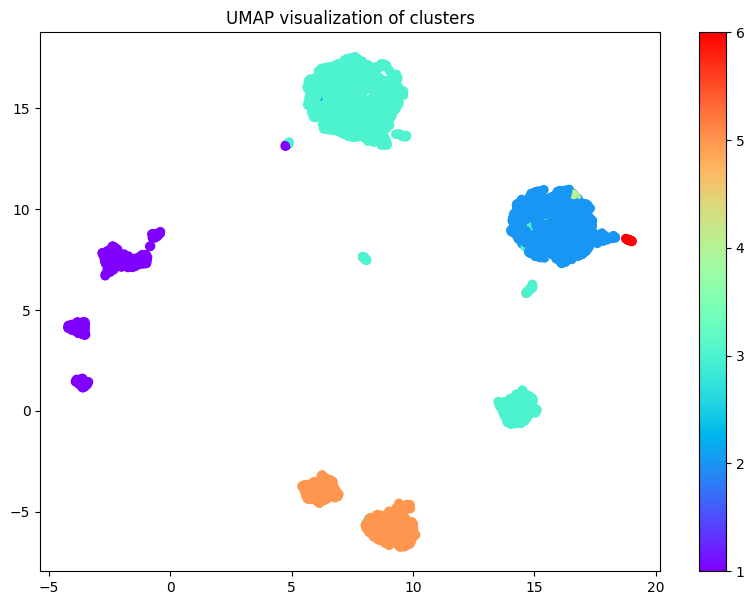

In [28]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# UMAPの適用
reducer = umap.UMAP(random_state=42)
sample_df_umap = reducer.fit_transform(sample_df_scaled)

# 可視化
plt.figure(figsize=(10, 7))
plt.scatter(sample_df_umap[:, 0], sample_df_umap[:, 1], c=sample_df['cluster'], cmap='rainbow')
plt.colorbar()
plt.title("UMAP visualization of clusters")
plt.show()

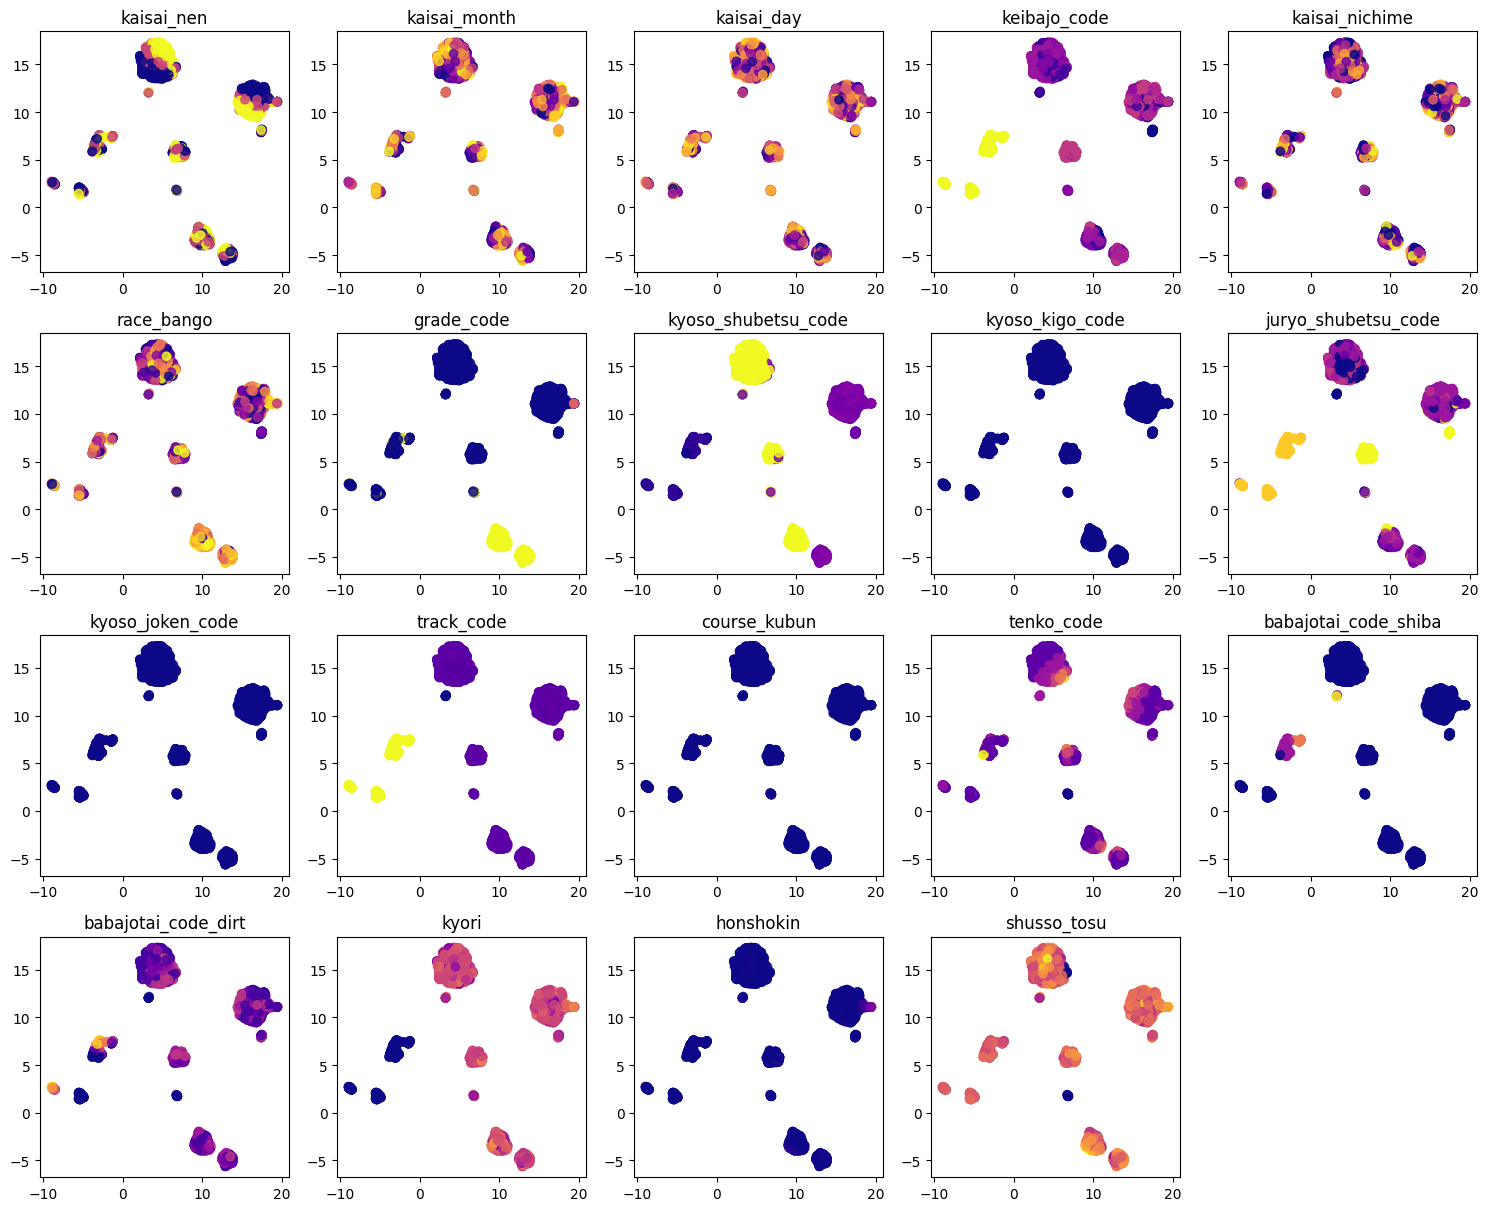

In [29]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(sample_df_scaled)

# 可視化
fig = plt.figure(figsize=(15,15))

for i, col in enumerate(column_list):
    if i >= 25:  # 最大25のサブプロットのみ表示
        break
    ax = fig.add_subplot(5, 5, i+1, title=col)
    ax.scatter(embedding[:, 0], embedding[:, 1],
               c=sample_df_encoded[col], cmap='plasma', alpha=0.8)

fig.tight_layout()
plt.show()

In [45]:
import seaborn as sns

print(sample_df['cluster'].value_counts())

cluster
3    1894
2    1261
5     804
1     529
6      19
4       4
Name: count, dtype: int64


Crosstab result for column: kaisai_nen
kaisai_nen  2020  2021  2022
cluster                     
1            167   172   190
2            412   413   436
3            688   591   615
4              0     3     1
5            263   268   273
6              7     6     6


Crosstab result for column: kaisai_month
kaisai_month   1    2    3    4    5    6    7    8    9    10   11   12
cluster                                                                 
1              51   46   42   24   46   42   56   45   36   56   43   42
2              84   77  110   98  136  142  118  103  130   80   97   86
3             137  101  150  161  187  137  159  157  162  185  173  185
4               0    2    0    0    0    0    0    0    0    0    0    2
5              58   46   60   59   63   61   73   75  102   74   65   68
6               0    1    2    0    1    1    3    2    1    1    6    1


Crosstab result for column: kaisai_day
kaisai_day  1   2   3   4   5   6   7   8   9   10  11  12  1

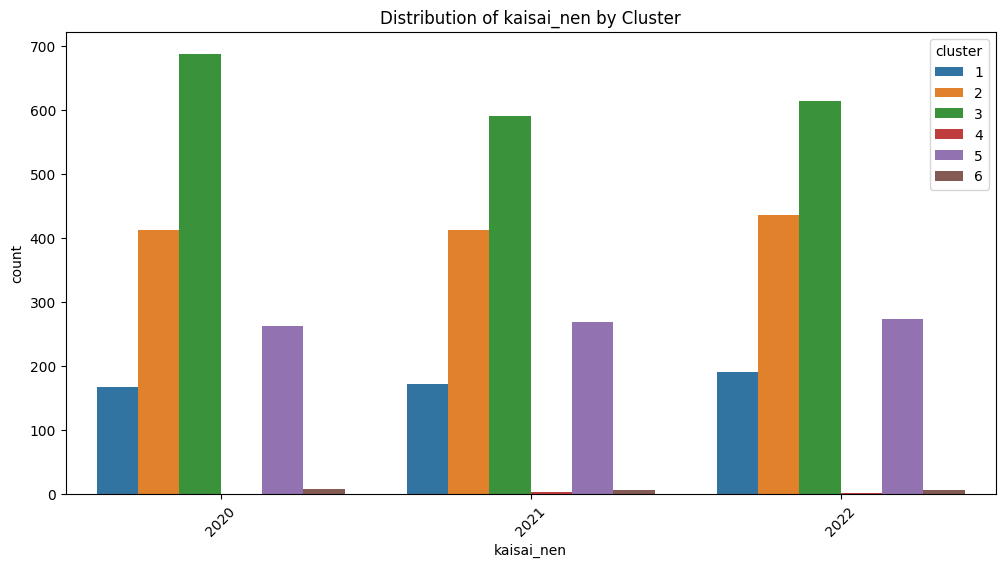

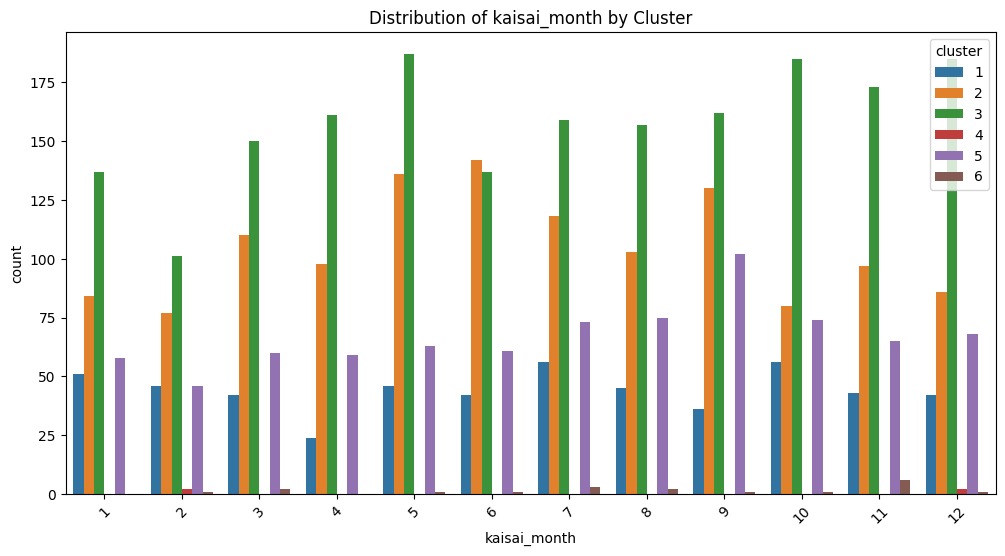

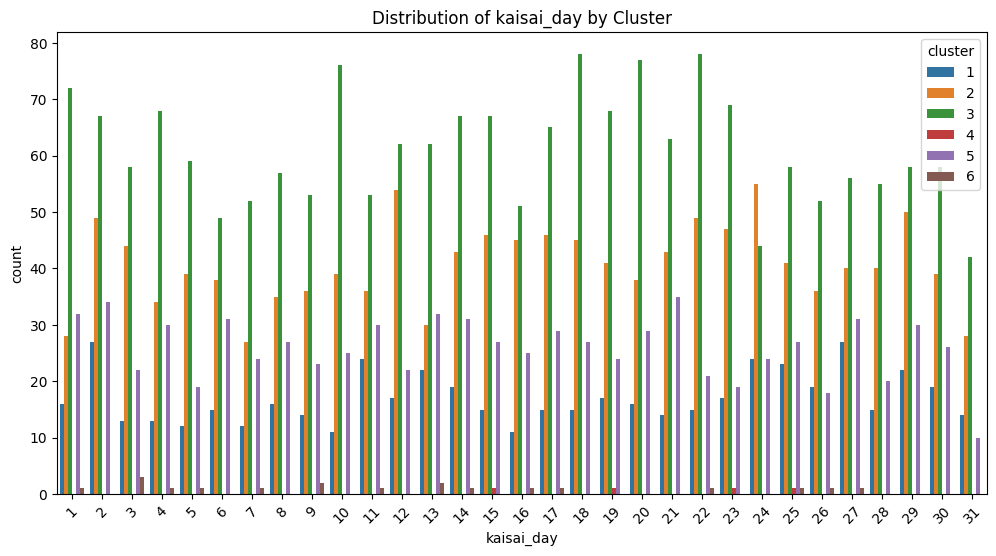

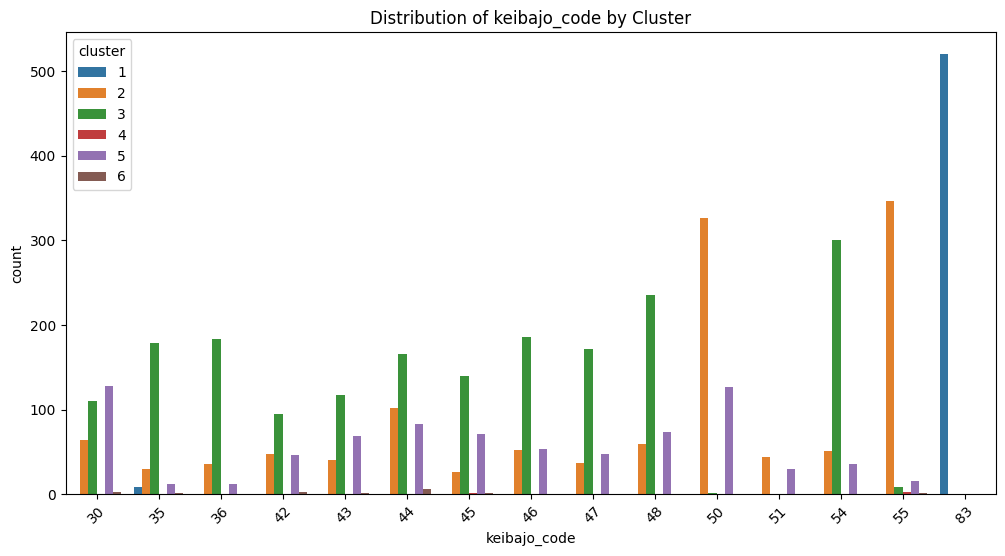

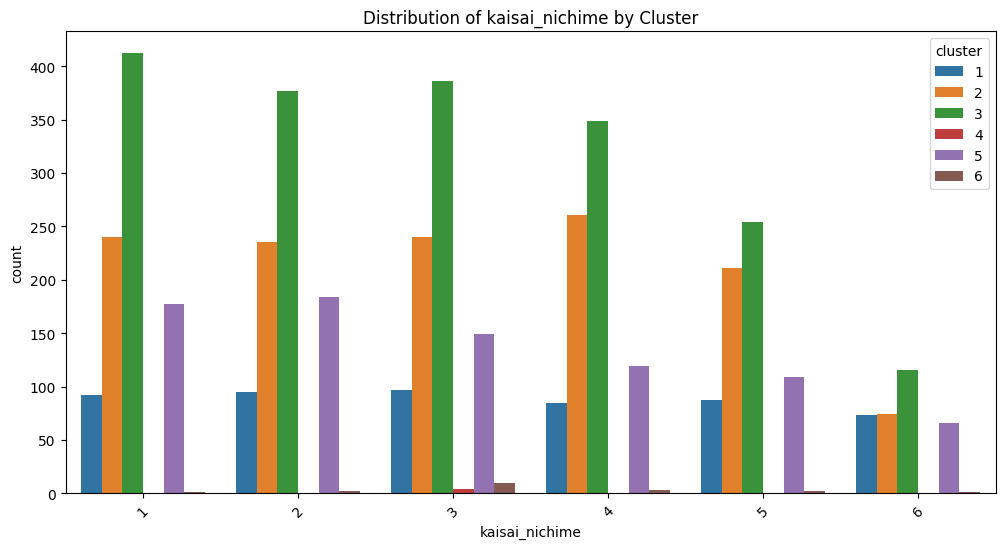

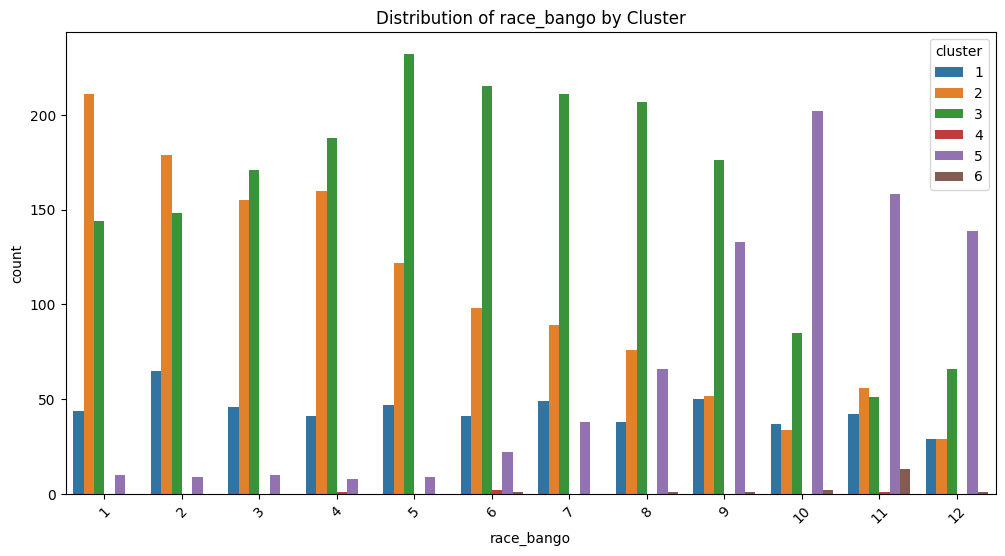

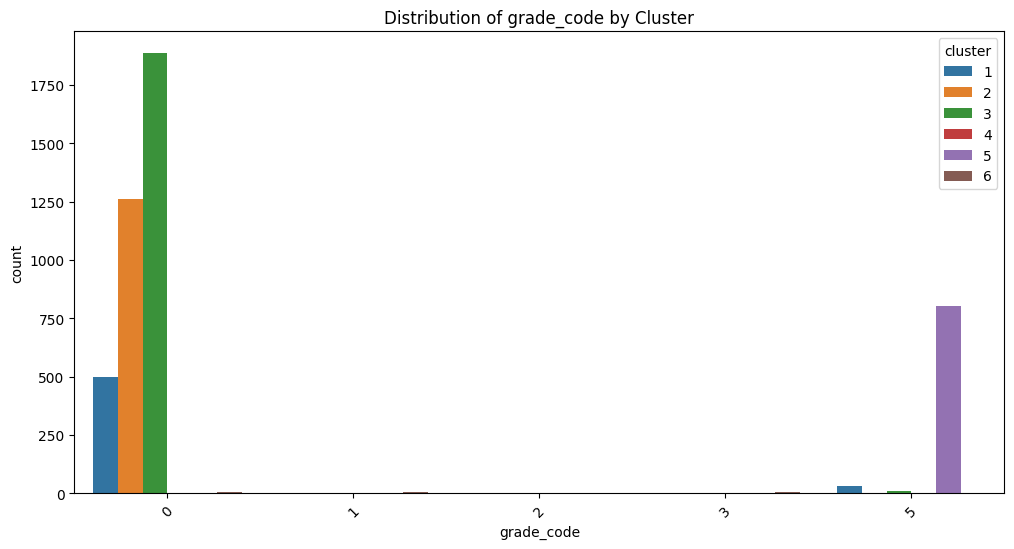

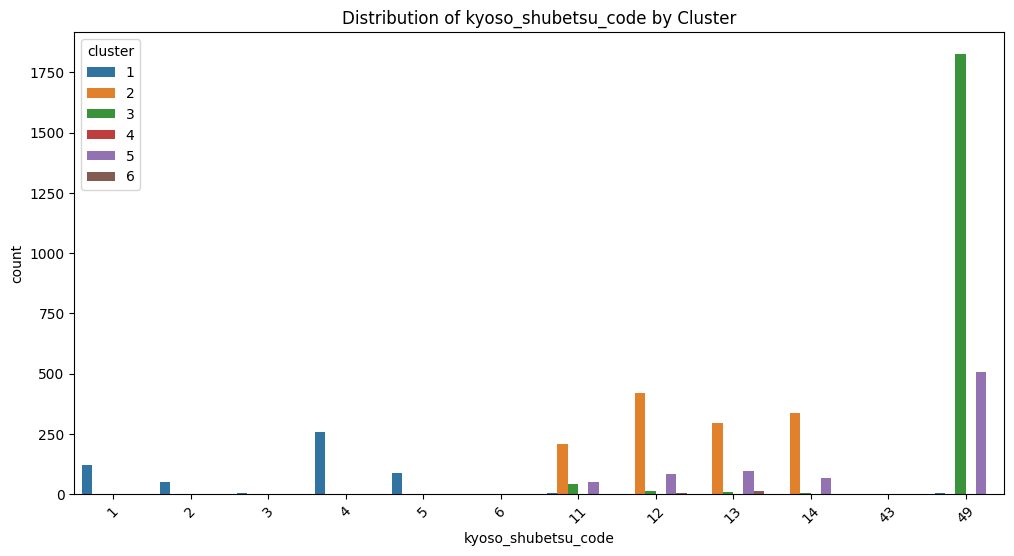

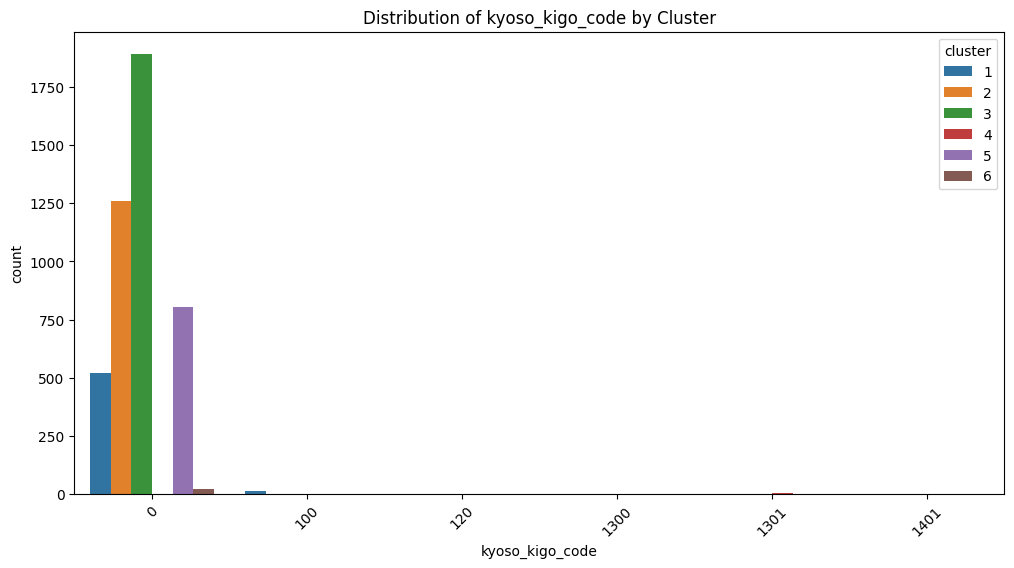

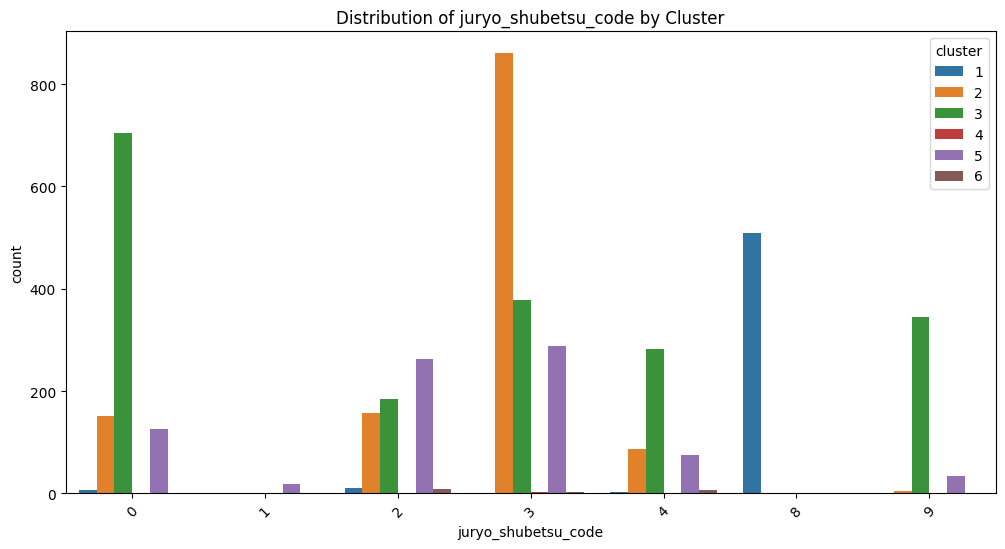

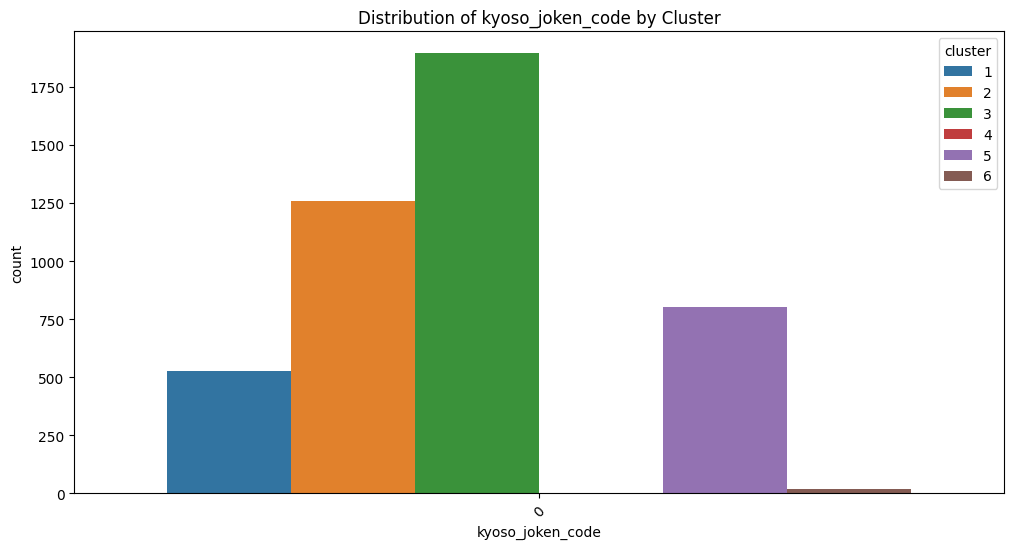

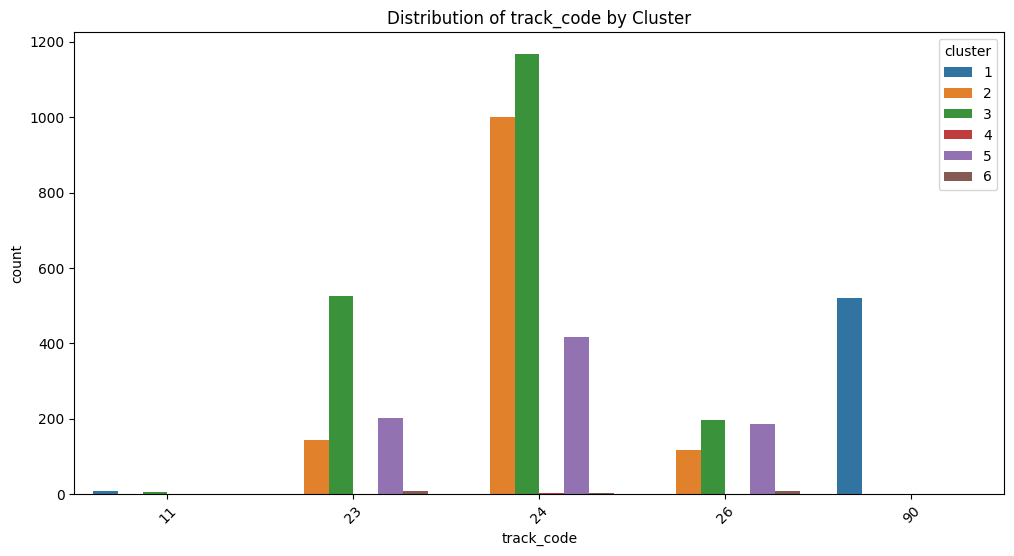

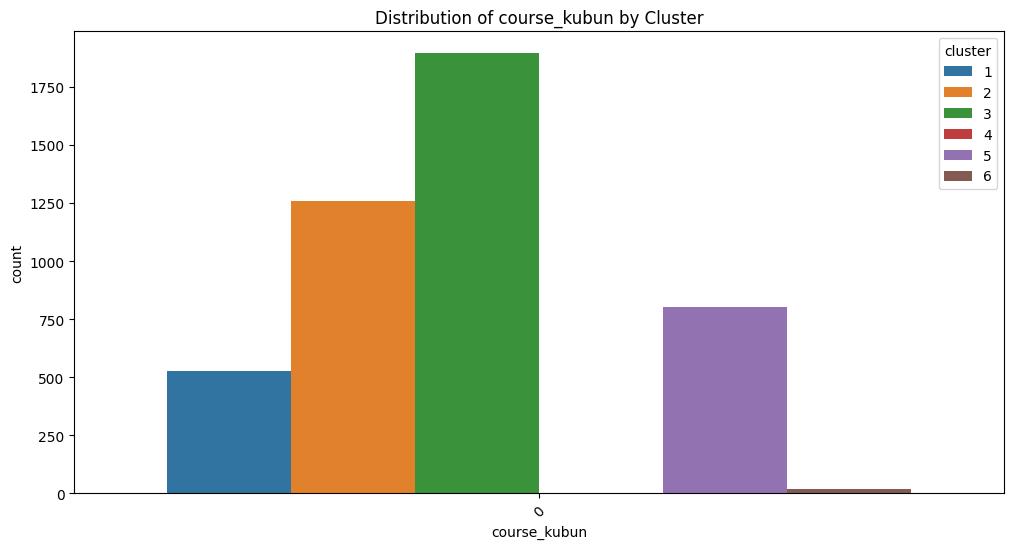

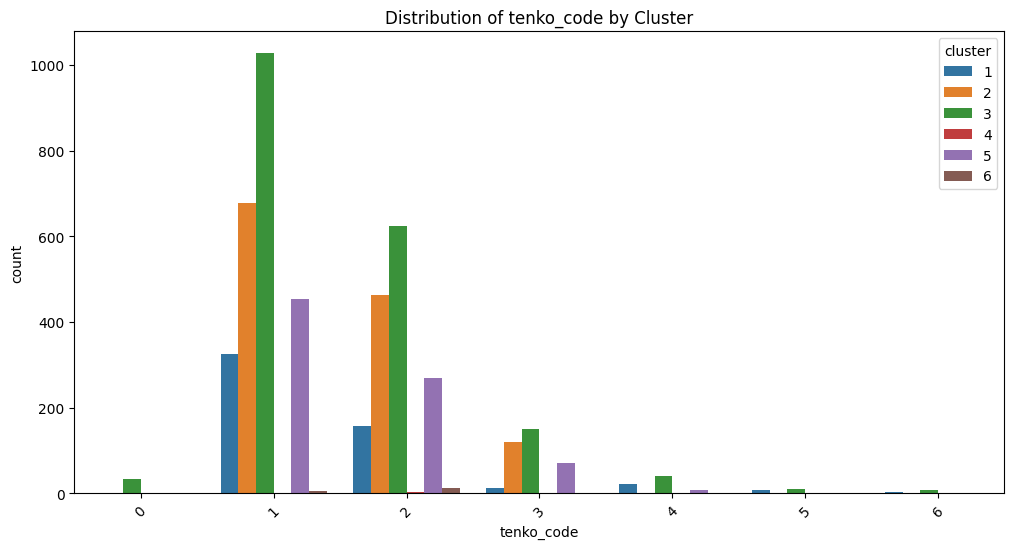

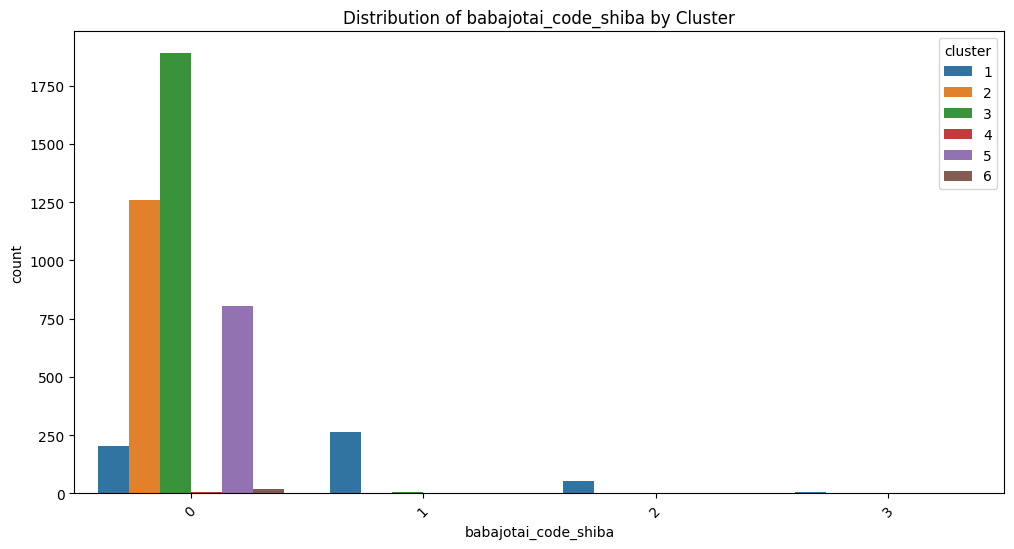

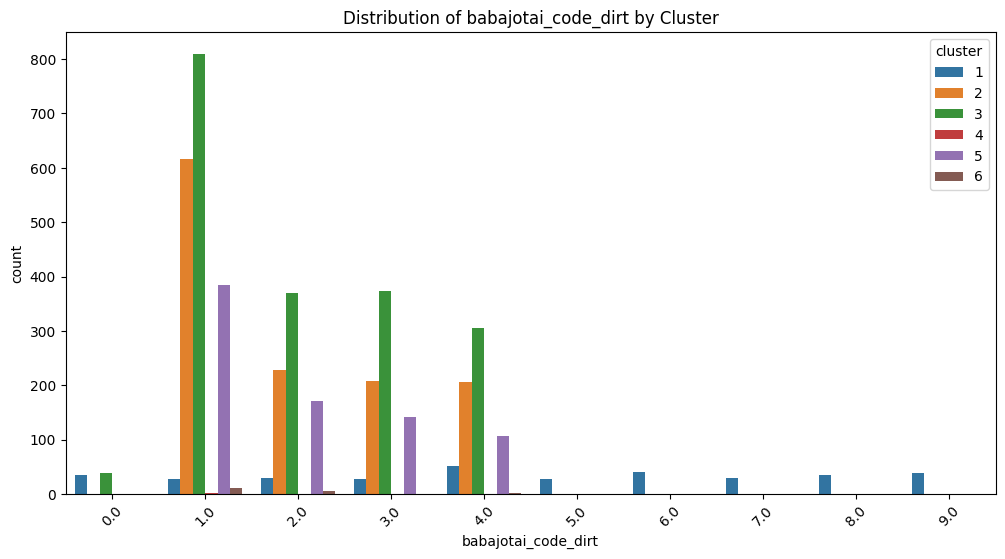

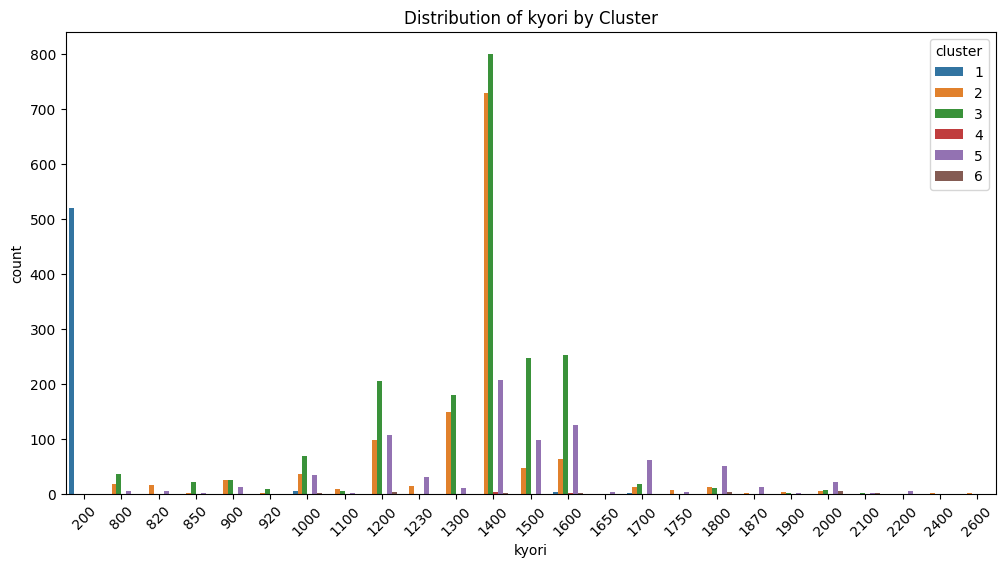

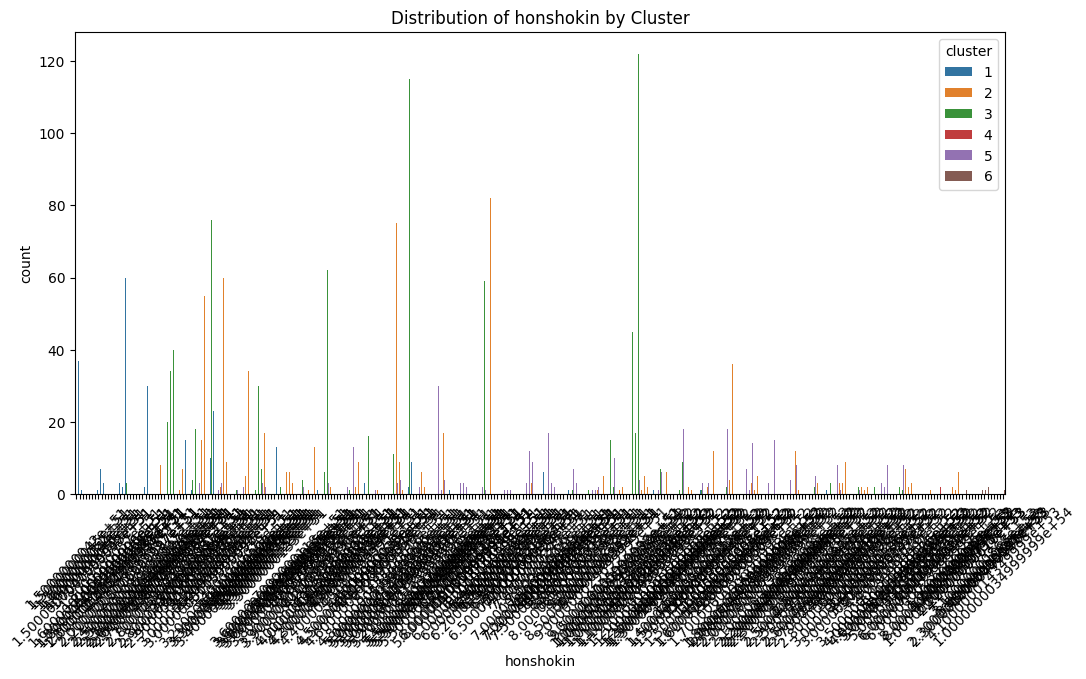

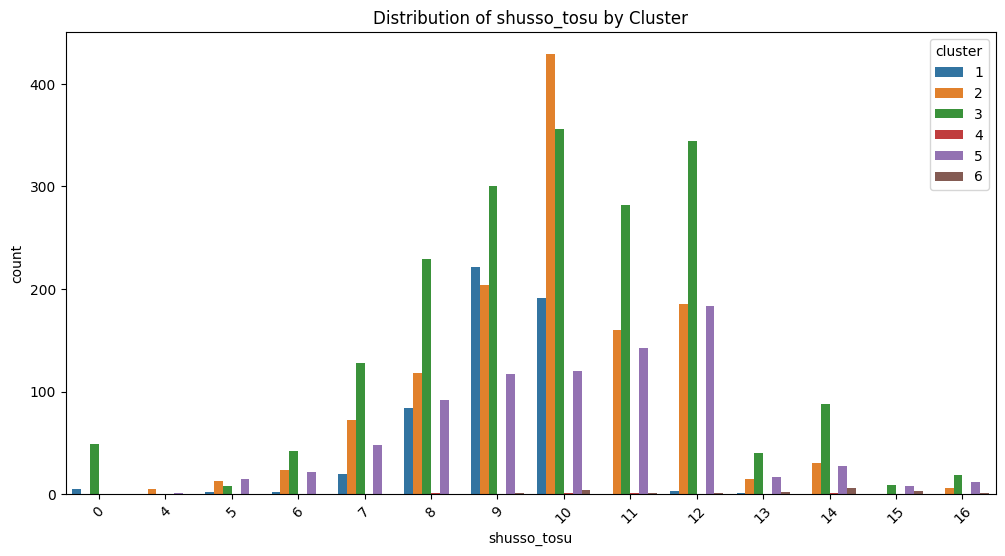

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# クロスタブを用いて各カテゴリカル変数のクラスタ内での分布を確認
for column in column_list:
    crosstab_result = pd.crosstab(sample_df['cluster'], sample_df[column])
    print(f"Crosstab result for column: {column}")
    print(crosstab_result)
    print("\n")

# 棒グラフを用いて可視化
for column in column_list:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=sample_df, x=column, hue='cluster')
    plt.title(f'Distribution of {column} by Cluster')
    plt.xticks(rotation=45)
    plt.show()


In [46]:
average_values = sample_df.groupby('cluster')[['is_correct', 'profit']].mean()

# 結果を表示
print(average_values)

         is_correct       profit
cluster                         
1          0.207940  -255.935728
2          0.249009  -369.222839
3          0.261352  -259.062500
4          0.000000 -1000.000000
5          0.248756  -335.447761
6          0.105263  -755.789474
